# Feature engineering and model optimization

Lag Features: Prices today often depend on prices in the past — the model can’t infer that automatically from timestamps, so we explicitly provide recent values.

* lag 1 = 1 month
* lag 3 = 3 months
* lag 6 = 6 months

Rolling statistics: Beyond single past points, we want the model to know recent trend and volatility.
* roll_mean_3 = mean of previous 3 months
* roll_std_3 = standard deviation of previous 3 months
* roll_mean_6 = mean of previous 6 months

Seasonal encoding: This gives two coordinates on the unit circle — January and December are now close again. Models can then learn patterns like “prices rise around harvest season” continuously across years.

In [97]:
import os
os.chdir('/Users/nataschajademinnitt/Documents/5_data/food_security/')

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from etl.staples_model_core import (
    impute_features,
    build_features,
    encode_ids,
    pick_features,
    time_split,
    tune_xgb,
    fit_xgb_compat,
    smape,
    rmse,
    TEST_HORIZON_MONTHS,
    N_TRIALS,
    SEED,
)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [111]:
df['product'].unique()

array(['Maize Grain (White)', 'Mixed Teff', 'Refined sugar', 'Sorghum',
       'Wheat Grain', 'Beans (Haricot)', 'Refined Vegetable Oil',
       'Rice (Milled)', 'Wheat Flour'], dtype=object)

In [101]:
PARQUET_PATH = "data/processed/ethiopia_foodprices_model_panel_tierA.parquet"
df = pd.read_parquet(PARQUET_PATH)

# Build StatsForecast-format panel: unique_id, ds, y
df_sf = (
    df.rename(columns={"month": "ds", "value_imputed": "y"})
      .assign(
          ds=lambda d: pd.to_datetime(d["ds"], errors="coerce")
                        .dt.to_period("M").dt.to_timestamp("M"),   # month-end stamps
          unique_id=lambda d: d["admin_1"].astype(str) + " · " + d["product"].astype(str)
      )[["unique_id", "ds", "y"]]
      .groupby(["unique_id", "ds"], as_index=False)["y"].mean()
      .sort_values(["unique_id", "ds"])
)

# Per-series split: last h for test
h = 3

# Remove series with fewer than h+1 points (need at least one train obs)
counts = df_sf.groupby("unique_id")["ds"].count()
ok_ids = counts[counts > h].index

df_sf = df_sf[df_sf["unique_id"].isin(ok_ids)].reset_index(drop=True)

test = df_sf.groupby("unique_id", group_keys=False).tail(h).reset_index(drop=True)
train = (
    df_sf.groupby("unique_id", group_keys=False)
         .apply(lambda g: g.iloc[:-h])
         .reset_index(drop=True)
)

In [104]:
df_sf.head()

,unique_id,ds,y
0,Afar · Maize Grain (White),2020-10-31,14.4
1,Afar · Maize Grain (White),2020-11-30,14.3
2,Afar · Maize Grain (White),2020-12-31,18.0
3,Afar · Maize Grain (White),2021-01-31,14.3
4,Afar · Maize Grain (White),2021-02-28,14.3


## Baseline models

  metric     Naive  WindowAverage     ARIMA    SARIMA
0    mae  5.788158      14.635632  7.941740  7.066369
1   mape  0.059452       0.119021  0.078887  0.075276
2   rmse  7.104745      15.319795  9.218102  8.234693
3  smape  0.030174       0.061602  0.038328  0.036483


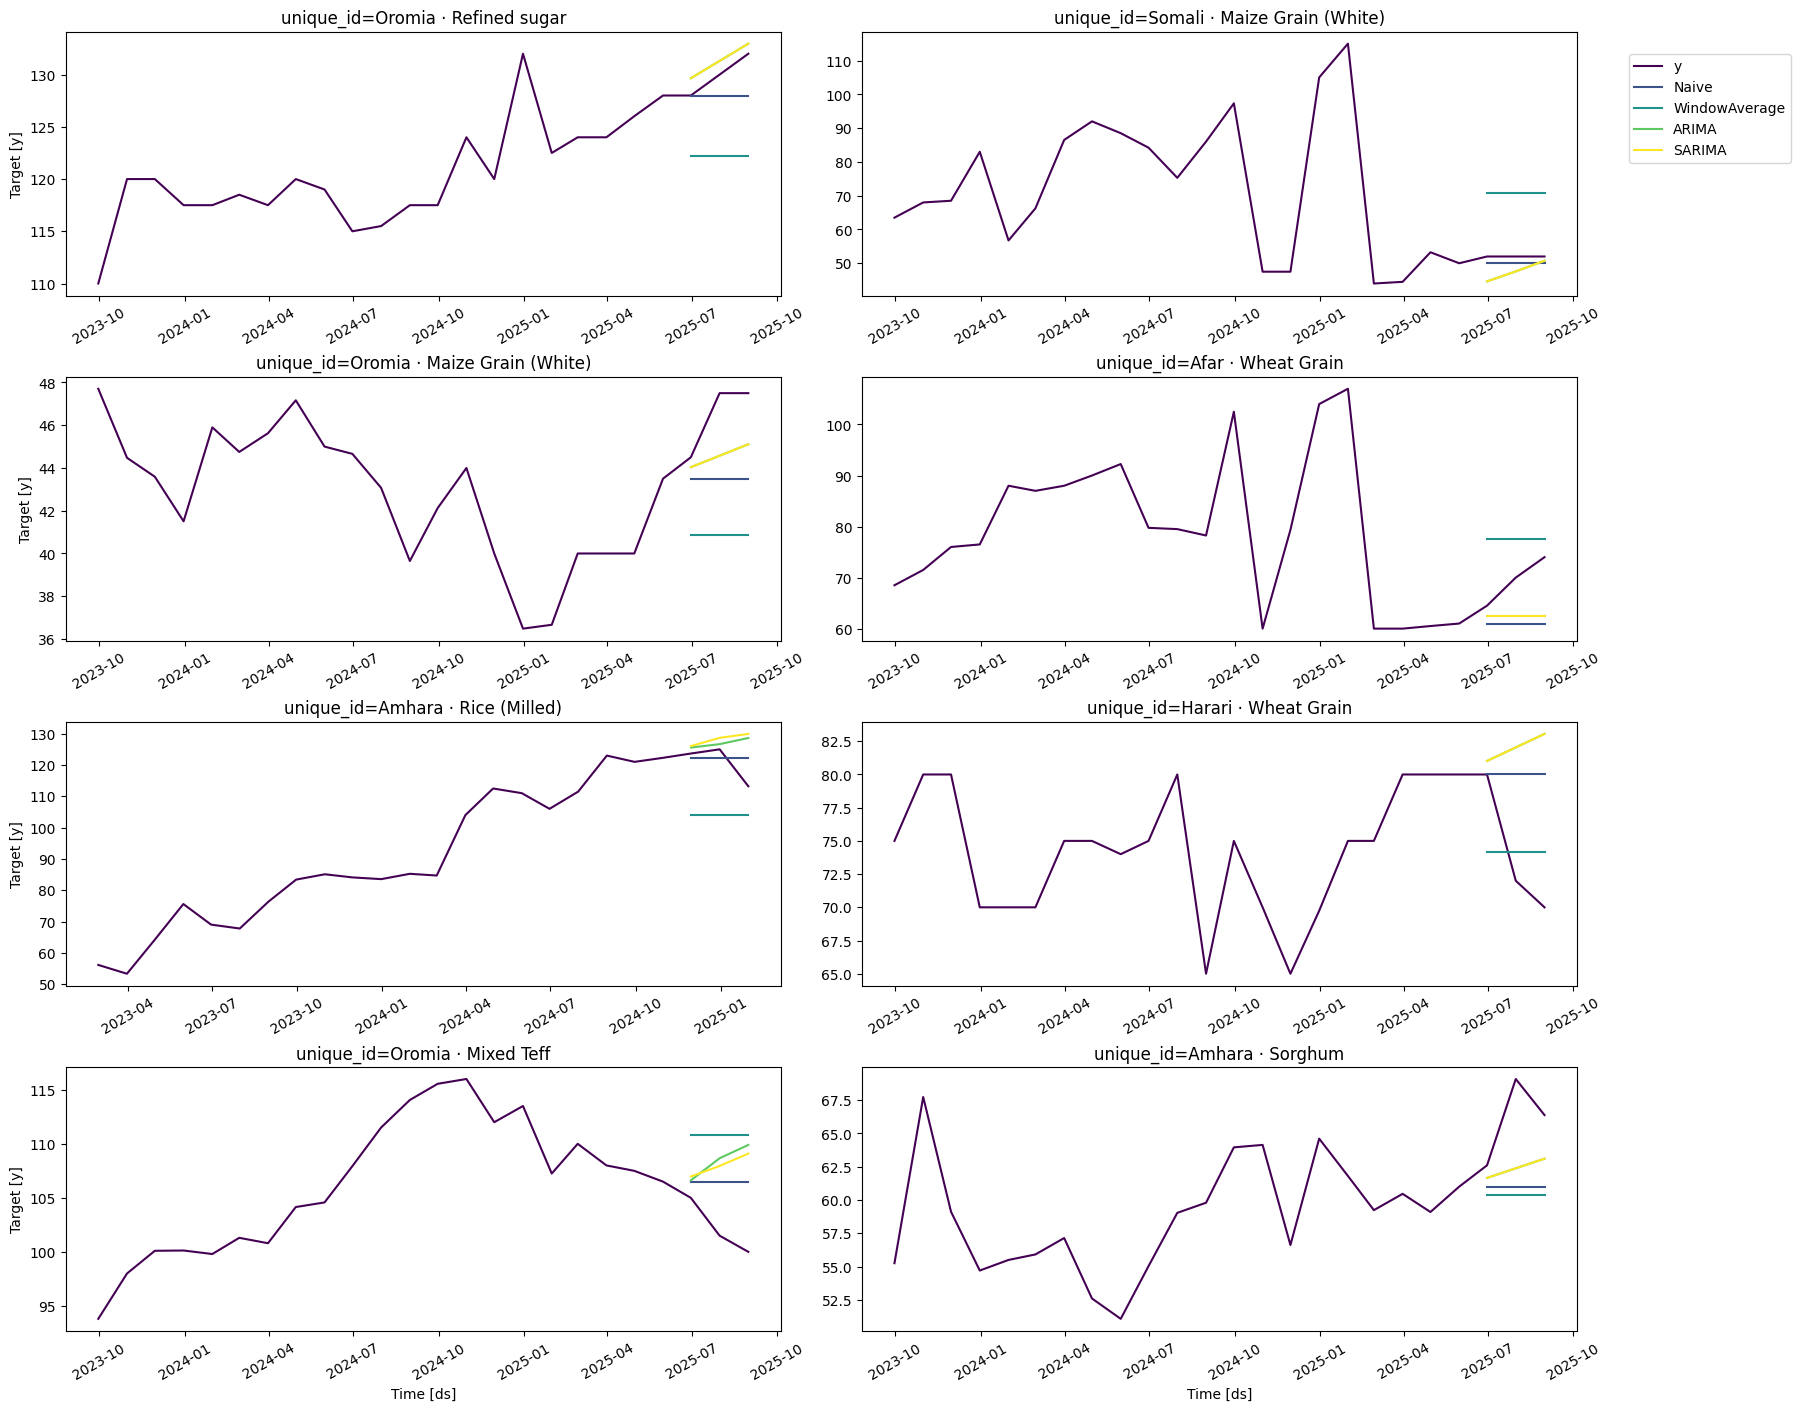

In [75]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive
from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate
from statsforecast.models import AutoARIMA

# Models
models = [
    # Baseline models
    Naive(),
    WindowAverage(window_size=12),

    # Statistical models
    AutoARIMA(seasonal=False, alias='ARIMA'),
    AutoARIMA(season_length=12, alias='SARIMA'),
]

# Fit and predict (freq='M' = month-end)
sf = StatsForecast(models=models, freq="M", n_jobs=-1)
sf.fit(df=train)
preds = sf.predict(h=h)  # returns columns per model alongside unique_id, ds

# Join true vs preds for evaluation
eval_df = test.merge(preds, on=["unique_id", "ds"], how="left")

# Evaluate across all models
evaluation = evaluate(
    eval_df,
    metrics=[mae, mape, rmse, smape],
)

evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
print(evaluation)

plot_series(
    df=df_sf,
    forecasts_df=preds,
    max_insample_length=24,
    palette="viridis"
)

The monthly series are highly persistent with limited exploitable seasonality post-2020. A last-value (or last-value-with-drift) baseline is very hard to beat globally.

  metric      Naive      ARIMA     SARIMA
0    mae   9.381718  10.314001  10.016463
1   mape   0.083792   0.103546   0.101155
2   rmse  12.845078  13.164075  12.817085
3  smape   0.045330   0.051143   0.050451


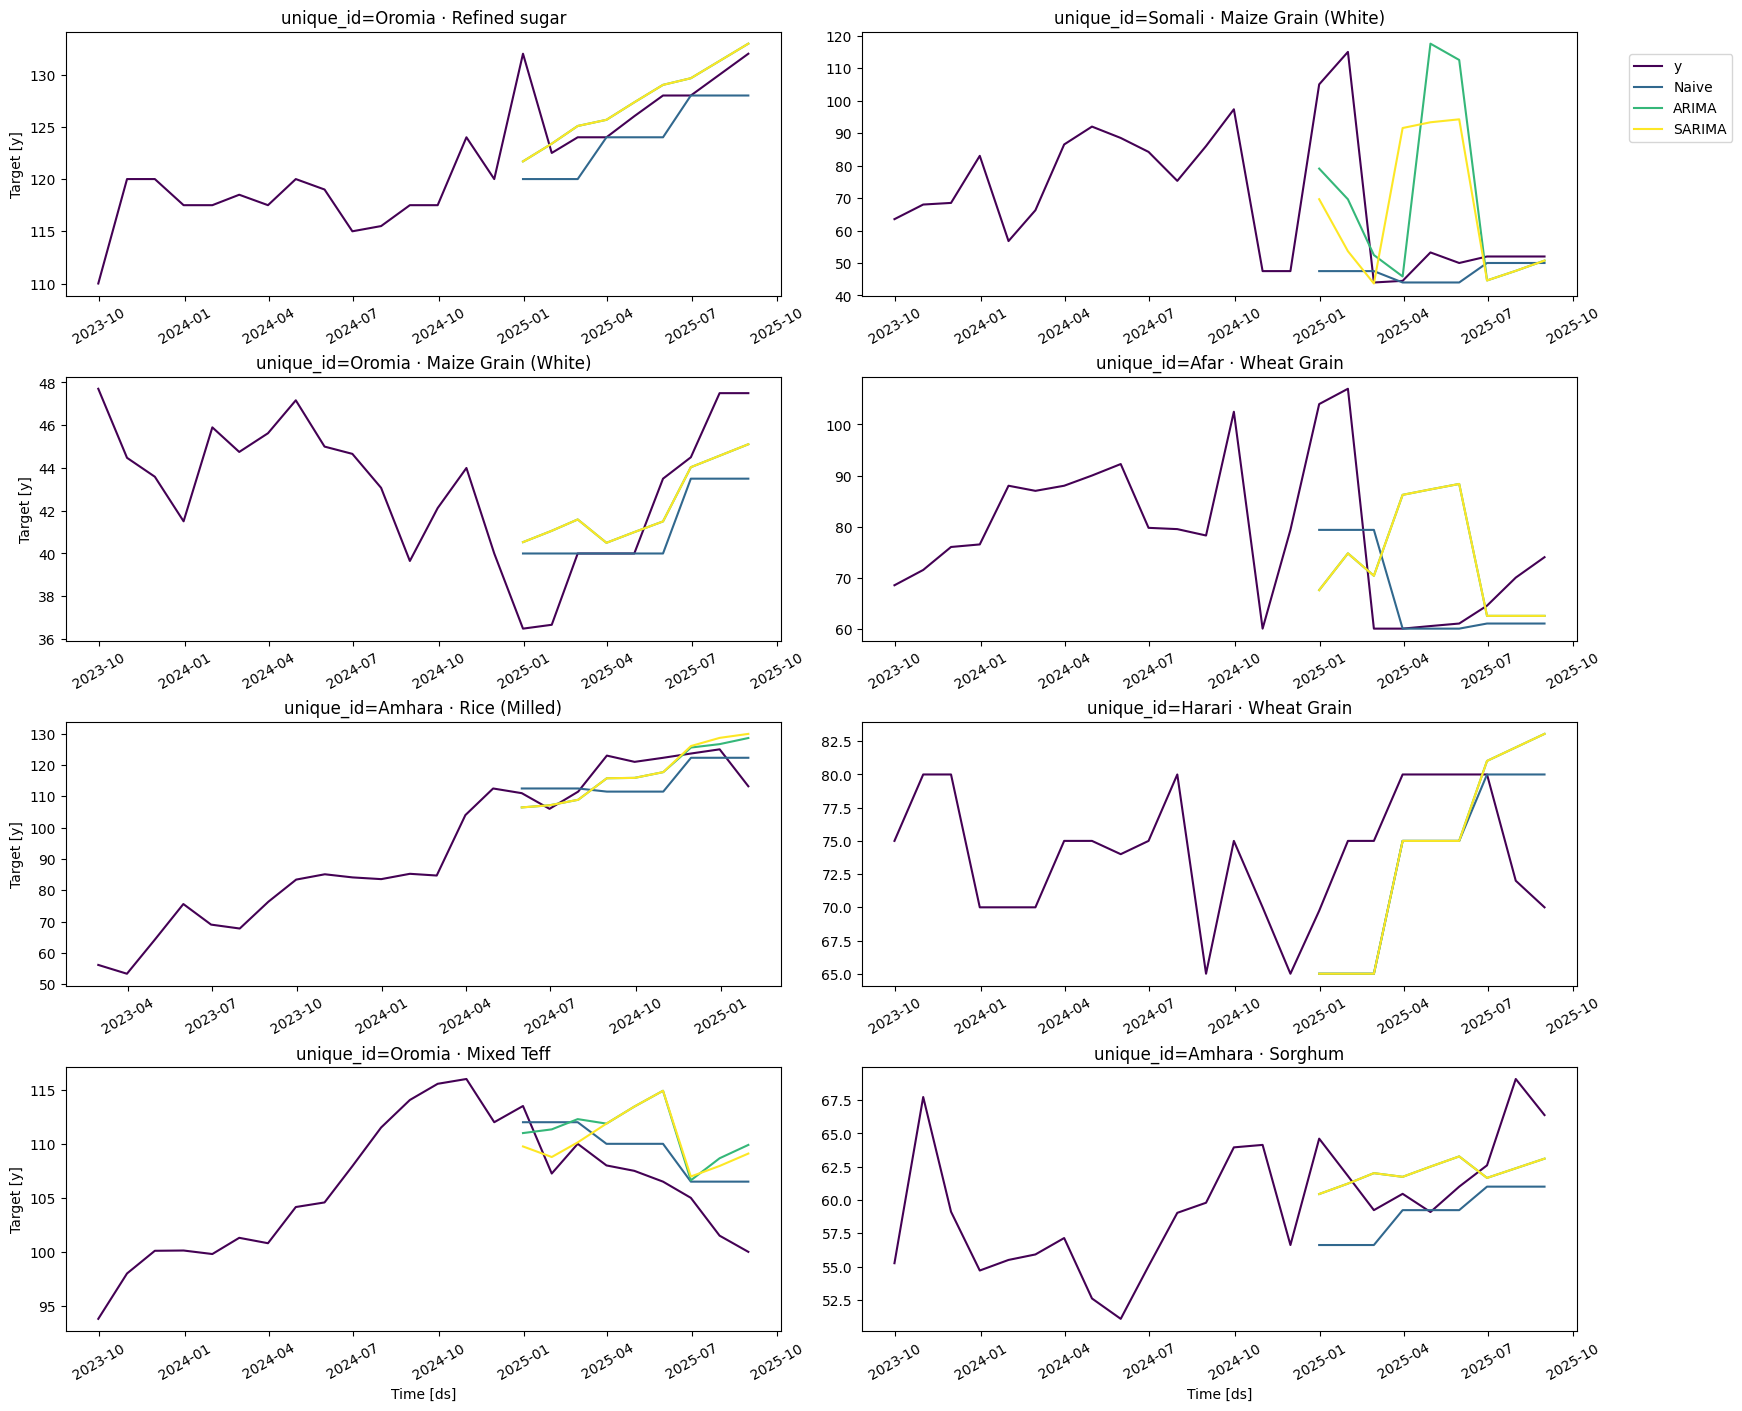

In [82]:
# Using cross-validation

# Models
models = [
    # Baseline models
    Naive(),

    # Statistical models
    AutoARIMA(seasonal=False, alias='ARIMA'),
    AutoARIMA(season_length=12, alias='SARIMA'),
]

# Fit and predict (freq='M' = month-end)
sf = StatsForecast(models=models, freq="M", n_jobs=-1)

cv_df = sf.cross_validation(
    h=h,
    df=df_sf,
    n_windows=3,
    step_size=h,
    refit=True
)

cv_eval = evaluate(
    cv_df.drop(['cutoff'], axis=1),
    metrics=[mae, mape, rmse, smape],
)

cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
print(cv_eval)

plot_series(
    df=df_sf,
    forecasts_df=cv_df.drop(['y', 'cutoff'], axis=1),
    max_insample_length=24,
    palette="viridis"
)

In [ ]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

features = [
    partial(fourier, season_length=12, k=3),                 # annual seasonality on monthly data
    partial(time_features, features=['month', 'quarter', 'year']),
]

# Historical exog aligned to df_sf
X_df = pipeline(
    df=df_sf,
    features=features,
    freq='M',
    h=0            # only in-sample features
)

# Future exog for next h months
futr_exog = pipeline(
    df=df_sf,
    features=features,
    freq='M',
    h=h            # creates h future rows per unique_id
)


AttributeError: 'tuple' object has no attribute 'columns'

In [ ]:
# Using cross-validation

# Models
models = [
    # Baseline models
    Naive(),

    # Statistical models
    AutoARIMA(seasonal=False, alias='ARIMA'),
    AutoARIMA(season_length=12, alias='SARIMA'),
]

# Fit and predict (freq='M' = month-end)
sf = StatsForecast(models=models, freq="M", n_jobs=-1)

cv_df = sf.cross_validation(
    h=h,
    df=df_sf,
    n_windows=3,
    step_size=h,
    refit=True
)

cv_eval = evaluate(
    cv_df.drop(['cutoff'], axis=1),
    metrics=[mae, mape, rmse, smape],
)

cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
print(cv_eval)

plot_series(
    df=df_sf,
    forecasts_df=cv_df.drop(['y', 'cutoff'], axis=1),
    max_insample_length=24,
    palette="viridis"
)

In [ ]:
import mlflow

mlflow.set_experiment("ethiopia_food_prices")


In [2]:
# ============================== LOAD PIPELINE ===============================
PARQUET_PATH = "data/processed/ethiopia_foodprices_model_panel_tierA.parquet"
panel = pd.read_parquet(PARQUET_PATH)

print("Top-level columns:", list(panel.columns))
assert "rfh_month" in panel.columns or True

# Feature engineering
staples = impute_features(panel)
df_feat = build_features(staples)
df_feat = encode_ids(df_feat)
df_feat = df_feat.sort_values(["month", "admin_1", "product"]).reset_index(drop=True)
feats = pick_features(df_feat)
df_feat[feats] = df_feat[feats].apply(pd.to_numeric, errors="coerce").astype("float32")

# Split
train_df, test_df = time_split(df_feat, horizon=TEST_HORIZON_MONTHS)
X_train, X_test = train_df[feats], test_df[feats]
y_train_log = np.log1p(train_df["y"])
y_test_true = test_df["y"].to_numpy()

Top-level columns: ['month', 'admin_1', 'product', 'unit', 'value_mean', 'value_median', 'n_obs', 'value_orig', 'value_imputed', 'impute_method', 'fao_category', 'fao_food_price_index', 'fao_category_index', 'Events', 'Fatalities', 'acled_missing', 'rfh_month', 'rfh_avg_month', 'rfq_month', 'rain_anom_pct', 'ptm_severity', 'population_2023', 'fx_official_etb_per_usd']
[impute_features] columns at entry: ['month', 'admin_1', 'product', 'unit', 'value_mean', 'value_median', 'n_obs', 'value_orig', 'value_imputed', 'impute_method', 'fao_category', 'fao_food_price_index', 'fao_category_index', 'Events', 'Fatalities', 'acled_missing', 'rfh_month', 'rfh_avg_month', 'rfq_month', 'rain_anom_pct', 'ptm_severity', 'population_2023', 'fx_official_etb_per_usd']


/Users/nataschajademinnitt/Documents/5_data/food_security/etl/staples_model_core.py:164: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("admin_1", group_keys=False)[c]


In [12]:
# ============================== CLASSICAL STATISTICAL MODELS ===============================

import numpy as np
import pandas as pd
from collections import defaultdict

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

GROUP_COLS = ["admin_1", "product"]
TARGET_COL = "y"
SEASONAL_PERIODS = 12  # monthly data

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not mask.any():
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5



def run_classical_baselines(train_df, test_df):
    """
    Train classical TS models per (admin_1, product) using your train/test split.
    Returns:
        metrics_df: one row per group × model with RMSE, MAPE
        preds_df: predictions merged to test_df (columns: y_pred_<model>)
    """
    min_test_month = test_df["month"].min()

    # We'll store predictions in a copy of test_df
    preds_df = test_df.copy()
    metrics_rows = []

    # For convenience, build an index into test_df rows by group
    test_index = test_df.set_index(GROUP_COLS + ["month"]).index

    # Unique groups in train (Tier A)
    groups = (
        train_df[GROUP_COLS]
        .drop_duplicates()
        .sort_values(GROUP_COLS)
        .to_records(index=False)
    )

    for admin_1, product in groups:
        g_key = (admin_1, product)

        # ----------------------
        # Extract group series
        # ----------------------
        g_train = (
            train_df
            .loc[(train_df["admin_1"] == admin_1) &
                 (train_df["product"] == product)]
            .sort_values("month")
        )
        g_test = (
            test_df
            .loc[(test_df["admin_1"] == admin_1) &
                 (test_df["product"] == product)]
            .sort_values("month")
        )

        if g_train.empty or g_test.empty:
            continue

        y_train = np.log(g_train.set_index("month")[TARGET_COL])
        y_test  = np.log(g_test.set_index("month")[TARGET_COL])

        # ----------------------
        # 1) Naive (last value)
        # ----------------------
        naive_forecast = pd.Series(
            y_train.iloc[-1],
            index=y_test.index,
            name="naive"
        )

        rmse_naive = mean_squared_error(y_test, naive_forecast)
        mape_naive = mape(y_test, naive_forecast)

        metrics_rows.append({
            "admin_1": admin_1,
            "product": product,
            "model": "naive",
            "rmse": rmse_naive,
            "mape": mape_naive,
        })

        colname_naive = "y_pred_naive"
        preds_df.loc[
            (preds_df["admin_1"] == admin_1) &
            (preds_df["product"] == product),
            colname_naive
        ] = naive_forecast.values

        # ----------------------
        # 2) Seasonal naive (12m)
        # ----------------------
        if len(y_train) > SEASONAL_PERIODS:
            seasonal_values = y_train[-SEASONAL_PERIODS:]
            # Repeat last season over the test horizon
            seasonal_forecast = pd.Series(
                np.tile(seasonal_values.values, int(np.ceil(len(y_test) / SEASONAL_PERIODS)))[:len(y_test)],
                index=y_test.index,
                name="seasonal_naive"
            )

            rmse_snaive = mean_squared_error(y_test, seasonal_forecast)
            mape_snaive = mape(y_test, seasonal_forecast)

            metrics_rows.append({
                "admin_1": admin_1,
                "product": product,
                "model": "seasonal_naive",
                "rmse": rmse_snaive,
                "mape": mape_snaive,
            })

            colname_snaive = "y_pred_seasonal_naive"
            preds_df.loc[
                (preds_df["admin_1"] == admin_1) &
                (preds_df["product"] == product),
                colname_snaive
            ] = seasonal_forecast.values

        # ----------------------
        # 3) ETS (Holt–Winters)
        # ----------------------
        try:
            ets_model = ExponentialSmoothing(
                y_train,
                trend="add",
                seasonal="add",
                seasonal_periods=SEASONAL_PERIODS,
            )
            ets_fit = ets_model.fit(optimized=True)
            ets_forecast = ets_fit.forecast(len(y_test))

            rmse_ets = mean_squared_error(y_test, ets_forecast)
            mape_ets = mape(y_test, ets_forecast)

            metrics_rows.append({
                "admin_1": admin_1,
                "product": product,
                "model": "ets_add_add",
                "rmse": rmse_ets,
                "mape": mape_ets,
            })

            colname_ets = "y_pred_ets"
            preds_df.loc[
                (preds_df["admin_1"] == admin_1) &
                (preds_df["product"] == product),
                colname_ets
            ] = ets_forecast.values

        except Exception as e:
            # Some series may be too short / weird for ETS; just skip
            print(f"[ETS] Skipped {g_key} due to {e}")

    metrics_df = pd.DataFrame(metrics_rows)
    return metrics_df, preds_df

metrics_df, preds_df = run_classical_baselines(train_df, test_df)

# Inspect average performance by model
print(
    metrics_df
    .groupby("model")[["rmse", "mape"]]
    .mean()
    .sort_values("rmse")
)

/Users/nataschajademinnitt/mamba/envs/foodsec/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/nataschajademinnitt/mamba/envs/foodsec/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/nataschajademinnitt/mamba/envs/foodsec/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/nataschajademinnitt/mamba/envs/foodsec/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/nataschajademinnitt/mamba/envs/foodsec/li

                    rmse      mape
model                             
naive           0.022548  2.468573
ets_add_add     0.023028  2.555097
seasonal_naive  0.070357  4.208531


In [ ]:


# --- NEW: require at least 12 months of history per (admin_1, product) ---

# How many distinct months of history do we have in the *training* period
hist_month_counts = (
    train_df
    .groupby(["admin_1", "product"])["month"]
    .nunique()
    .rename("n_hist_months")
    .reset_index()
)

# Attach this to the test set
test_df = test_df.merge(hist_month_counts,
                        on=["admin_1", "product"],
                        how="left")

# Flag whether we have ≥ 12 months of history
test_df["has_12m_hist"] = test_df["n_hist_months"].fillna(0) >= 12


# Tune & fit
print(f"Tuning global model ({N_TRIALS} trials)…")
best_params = tune_xgb(X_train, y_train_log, n_trials=N_TRIALS, seed=SEED)

last_train_m = train_df["month"].max()
val_cut = (last_train_m.to_period("M") - 2).to_timestamp()
val_mask = train_df["month"] >= val_cut
X_tr_es, y_tr_es = X_train[~val_mask], y_train_log[~val_mask]
X_va_es, y_va_es = X_train[val_mask],  y_train_log[val_mask]
if len(X_va_es) == 0:
    X_tr_es, y_tr_es = X_train, y_train_log
    X_va_es = y_va_es = None

final_model = fit_xgb_compat(
    best_params,
    X_tr_es,
    y_tr_es,
    X_va_es,
    y_va_es,
    early_rounds=200,
)

y_pred_test = np.expm1(final_model.predict(X_test))

# ---- HYBRID correction (per-product ridge on residuals) ----
train_df["y_pred_global"] = np.expm1(final_model.predict(X_train))
train_df["resid"] = train_df["y"] - train_df["y_pred_global"]

hybrid_models = {}
for prod, g in train_df.groupby("product", observed=False):
    if len(g) < 12:
        continue
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(alpha=2.0, fit_intercept=True, random_state=SEED)),
    ])
    Xp = g[["y_pred_global"]]  # simple, stable correction feature
    yp = g["resid"]
    pipe.fit(Xp, yp)
    hybrid_models[prod] = pipe

test_df["y_pred_global"] = y_pred_test

def _apply_hybrid(row):
    prod = row["product"]
    if prod not in hybrid_models:
        return row["y_pred_global"]
    Xcorr = pd.DataFrame([[row["y_pred_global"]]], columns=["y_pred_global"])
    corr = float(hybrid_models[prod].predict(Xcorr)[0])
    return row["y_pred_global"] + corr

test_df["y_pred_hybrid"] = test_df.apply(_apply_hybrid, axis=1)

# Any row without at least 12 months of history → no forecast
mask_ok = test_df["has_12m_hist"]
test_df = test_df[mask_ok].copy()
y_test_true = test_df["y"].to_numpy()

# ---- Metrics ----
valid_mask = test_df["y_pred_hybrid"].notna() & test_df["y"].notna()

print("\n=== STAPLES TEST METRICS (Hybrid, only where ≥12 months history) ===")

mae_val = mean_absolute_error(
    test_df.loc[valid_mask, "y"],
    test_df.loc[valid_mask, "y_pred_hybrid"]
)
rmse_val = rmse(
    test_df.loc[valid_mask, "y"],
    test_df.loc[valid_mask, "y_pred_hybrid"]
)
smape_val = smape(
    test_df.loc[valid_mask, "y"],
    test_df.loc[valid_mask, "y_pred_hybrid"]
)

print(f"MAE : {mae_val:,.3f}")
print(f"RMSE: {rmse_val:,.3f}")
print(f"sMAPE: {smape_val:.2f}%")


gg = test_df.loc[
    test_df["y_pred_hybrid"].notna() & test_df["y"].notna(),
    ["product", "y", "y_pred_hybrid"],
]
by_prod = (
    gg.assign(
        abs_err=lambda d: (d["y"] - d["y_pred_hybrid"]).abs(),
        sq_err=lambda d: (d["y"] - d["y_pred_hybrid"]) ** 2,
        denom=lambda d: (d["y"].abs() + d["y_pred_hybrid"].abs() + 1e-9) / 2.0,
        smape_i=lambda d: (d["y_pred_hybrid"] - d["y"]).abs() / d["denom"] * 100.0,
    )
    .groupby("product", observed=False)
    .agg(
        sMAPE=("smape_i", "mean"),
        MAE=("abs_err", "mean"),
        RMSE=("sq_err", lambda s: float(np.sqrt(s.mean()))),
        N=("y", "size"),
    )
    .reset_index()
    .sort_values("sMAPE", ascending=False)
)
print("\nWorst staples by sMAPE:")
print(by_prod.head(10).to_string(index=False))
